# K2DSE Benchmarks

This is a lab report of currents experiments with KDSE*

## What do we need to show 

### Goal 0 - re-implementation


First, I need to make sure my re-implementation is identical. Not trivial as we count SD differently.

#### 0.1 Count that the number of SD found is the same between OldKDSE,DKDSE,DKDSEA (the capstone implementation) and KDSE,K2DSE,K2DSEA (the paper re-implementation).

&#10004;  We are correct

#### 0.2 Verify that the algorithm isnt slower

&#10004;  We are faster 

#### 0.3 Check that the thread implementation is identical and also faster.

&#10004;  The implementation can explore more point given the concurrency effect over the end of exploration.
On large instances, there is a clear speed-up (when available).

### Goal 1 - Execution Time and size of explored space by DSE methods. 

#### generate the table 1 with KDSE,K2DSE,K2DSEA (no multi-thread).


### Goal 2 - Pareto fronts and explored space 

#### generate the Fig 3 with K2DSE,K2DSEA,PDSE (no multi-thread).

## Prepare data

In [1]:
import glob
import os.path
import pandas as pd 
import dsereader

logdir = "../../kdse2023_log/"
assert(os.path.exists(logdir))

application_names = {
    "bipartite" :  { "name" : "bipartite" },
    "fig8" :  { "name" : "fig8" },
    "modem" :  { "name" : "modem" },
    "sample" :  { "name" : "sample" },
    "satellite" :  { "name" : "satellite" },
    "samplerate"  :  { "name" : "samplerate" },
    "BlackScholes" :  { "name" : "BlackScholes" },
    "example" :  { "name" : "example" },
   "Echo" :  { "name" : "Echo" },
    "PDectect" :  { "name" : "PDectect" },
   "H264" :  { "name" : "H264" },
   "h263decoder" :  { "name" : "h263decoder" },
   "JPEG2000" :  { "name" : "JPEG2000" },
    "buffercycle" : { "name" : "buffercycle" },
}

method_names = {
 #  0 Infos
 #  1 Throughput   
    "kdse" : { "name" : "KDSE" ,      "color" : "black"},
    "k2dse" : { "name" : "K2DSE" ,     "color" : "black"}, 
    "k2dsea" : { "name" : "K2DSEA" ,     "color" : "black"}, 
    
    "k2dsec" : { "name" : "K2DSE w/ cache" ,     "color" : "black"}, 
    "k2dseac" : { "name" : "K2DSEA w/ cache" ,     "color" : "black"}, 
    
    "k2dsec24" : { "name" : "K2DSE C 24" ,     "color" : "black"}, 
    "k2dseac24" : { "name" : "K2DSEA  C 24" ,     "color" : "black"}, 
    
    "kdse8" : { "name" : "KDSE8" ,      "color" : "black"}, # "-athroughputbufferingDSE -prealtime=1 -pmode=KDSE -pthread=8" 
    "k2dse8" : { "name" : "K2DSE8" ,     "color" : "black"}, # "-athroughputbufferingDSE -prealtime=1 -pmode=K2DSE -pthread=8"
    "k2dsea8" : { "name" : "K2DSEA8" ,     "color" : "black"}, # "-athroughputbufferingDSE -prealtime=1 -pmode=K2DSEA -pthread=8"
    
#    8 : { "name" : "KDSE2" ,     "color" : "black"}, # "-athroughputbufferingDSE -prealtime=1 -pmode=KDSE -pthread=2"
#    8 : { "name" : "KDSE4" ,     "color" : "black"}, # "-athroughputbufferingDSE -prealtime=1 -pmode=KDSE -pthread=4"
#   10 : { "name" : "KDSE8" ,     "color" : "black"}, # "-athroughputbufferingDSE -prealtime=1 -pmode=KDSE -pthread=8"
#    9 : { "name" : "KDSE16" ,    "color" : "black"}, # "-athroughputbufferingDSE -prealtime=1 -pmode=KDSE -pthread=16"
}

In [2]:
import glob

import math
import datetime
def time_in_msec(time_msec): # copy pasted from https://stackoverflow.com/questions/48063828/convert-duration-format-from-float-to-monthdayshoursminutesseconds-in-python
    time_sec = int(time_msec // 1000)
    delta = datetime.timedelta(seconds=time_sec)
    delta_str = str(delta)[-8:]
    hours, minutes, seconds = [int(val) for val in delta_str.split(":", 3)]
    weeks = delta.days // 7
    days = delta.days % 7
    return "{}days {}h {}min {}.{}sec ({})".format(days, hours, minutes, seconds,int(time_msec) & 1000, time_msec)


def extract_throughput (throughput_file) :
    for line in open(throughput_file).read().split("\n"):
                if 'KPeriodic Throughput is' in line :
                    th = float(line.split(" ")[-1])
                    return th
    
    
def extract_task_count (infos_file) :
        for line in open(infos_file).read().split("\n"):
            if 'Task count' in line :
                count = int(line.split(" ")[-1])
                return count
    
def extract_logs (log_dir) :
    global application_names, method_names
    
    logs = {}
    
    # Collect all the filename
    for f in glob.glob(f"{log_dir}/*.txt") :
        name = f.split("/")[-1].split(".")[0]
        method = name.split("_")[1]
        application = name.split("_")[0]
        if application not in logs :
             logs [application] = { 'logs' : {} }
        
        logs [application] ["logs"] [method] =  f
        
    # Clean incomplete apps
    delete_them = set()
    for app in logs :
        if not "throughput" in logs[app]["logs"]  :
            delete_them.add(app)
        if not "infos" in logs[app]["logs"]  :
            delete_them.add(app)
    for app in delete_them :
        del logs[app]
            
    # Check missing apps amd methods
    for app in logs :
        if app not in application_names :
            print ("No such application", app)
            logs[app]["name"] =  app 
            application_names[app] = { "name" : app }
        else :
            logs[app]["name"] =  application_names[app]["name"]
            
        for method in logs[app]["logs"] :
            if method not in method_names and method not in ["throughput", "infos"]:
                print ("No such method", method)
                method_names[method] = { "name" : method , "color" : "black"}
                
    # Load task count and throughput       
    for app in logs :
        logs[app]["max_throughput"] = extract_throughput (logs[app]["logs"]["throughput"])
        logs[app]["task_count"] = extract_task_count (logs[app]["logs"]["infos"])
        del logs[app]["logs"]["throughput"]
        del logs[app]["logs"]["infos"]

    
    return logs

log_infos = extract_logs(logdir)

Produce subplot of 3 x 5
Load sample kdse KDSE
Loaded after 0.001775503158569336 sec.
Plot sample KDSE
Plotted after 0.007825136184692383 sec.
Load sample k2dse K2DSE
Loaded after 0.0010442733764648438 sec.
Plot sample K2DSE
Plotted after 0.006520271301269531 sec.
Load sample k2dsea K2DSEA
Loaded after 0.0010495185852050781 sec.
Plot sample K2DSEA
Plotted after 0.0064733028411865234 sec.
Load sample k2dsec K2DSE w/ cache
Loaded after 0.0009138584136962891 sec.
Plot sample K2DSE w/ cache
Plotted after 0.0061643123626708984 sec.
Load sample k2dseac K2DSEA w/ cache
Loaded after 0.0008802413940429688 sec.
Plot sample K2DSEA w/ cache
Plotted after 0.00629115104675293 sec.
Load sample k2dsec24 K2DSE C 24
Loaded after 0.0011751651763916016 sec.
Plot sample K2DSE C 24
Plotted after 0.006842136383056641 sec.
Load sample k2dseac24 K2DSEA  C 24
Loaded after 0.001018524169921875 sec.
Plot sample K2DSEA  C 24
Plotted after 0.006475925445556641 sec.
Load sample kdse8 KDSE8
Loaded FAILED after 0.0001

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Loaded after 0.6824607849121094 sec.
Plot H264 K2DSEA  C 24
Plotted after 0.003339052200317383 sec.
Load H264 kdse8 KDSE8
Loaded FAILED after 0.00019502639770507812 sec.
Load H264 k2dse8 K2DSE8
Loaded FAILED after 0.000152587890625 sec.
Load H264 k2dsea8 K2DSEA8
Loaded FAILED after 0.0001373291015625 sec.
Finished in 2.071676254272461 sec.

Load JPEG2000 kdse KDSE
Loaded after 0.06377506256103516 sec.
Plot JPEG2000 KDSE
Plotted after 0.0031118392944335938 sec.
Load JPEG2000 k2dse K2DSE
Loaded after 0.06537246704101562 sec.
Plot JPEG2000 K2DSE
Plotted after 0.006815910339355469 sec.
Load JPEG2000 k2dsea K2DSEA
Loaded after 0.06963515281677246 sec.
Plot JPEG2000 K2DSEA
Plotted after 0.007904052734375 sec.
Load JPEG2000 k2dsec K2DSE w/ cache
Loaded after 0.04861593246459961 sec.
Plot JPEG2000 K2DSE w/ cache
Plotted after 0.0070040225982666016 sec.
Load JPEG2000 k2dseac K2DSEA w/ cache
Loaded after 0.06684041023254395 sec.
Plot JPEG2000 K2DSEA w/ cache
Plotted after 0.007315158843994141 se

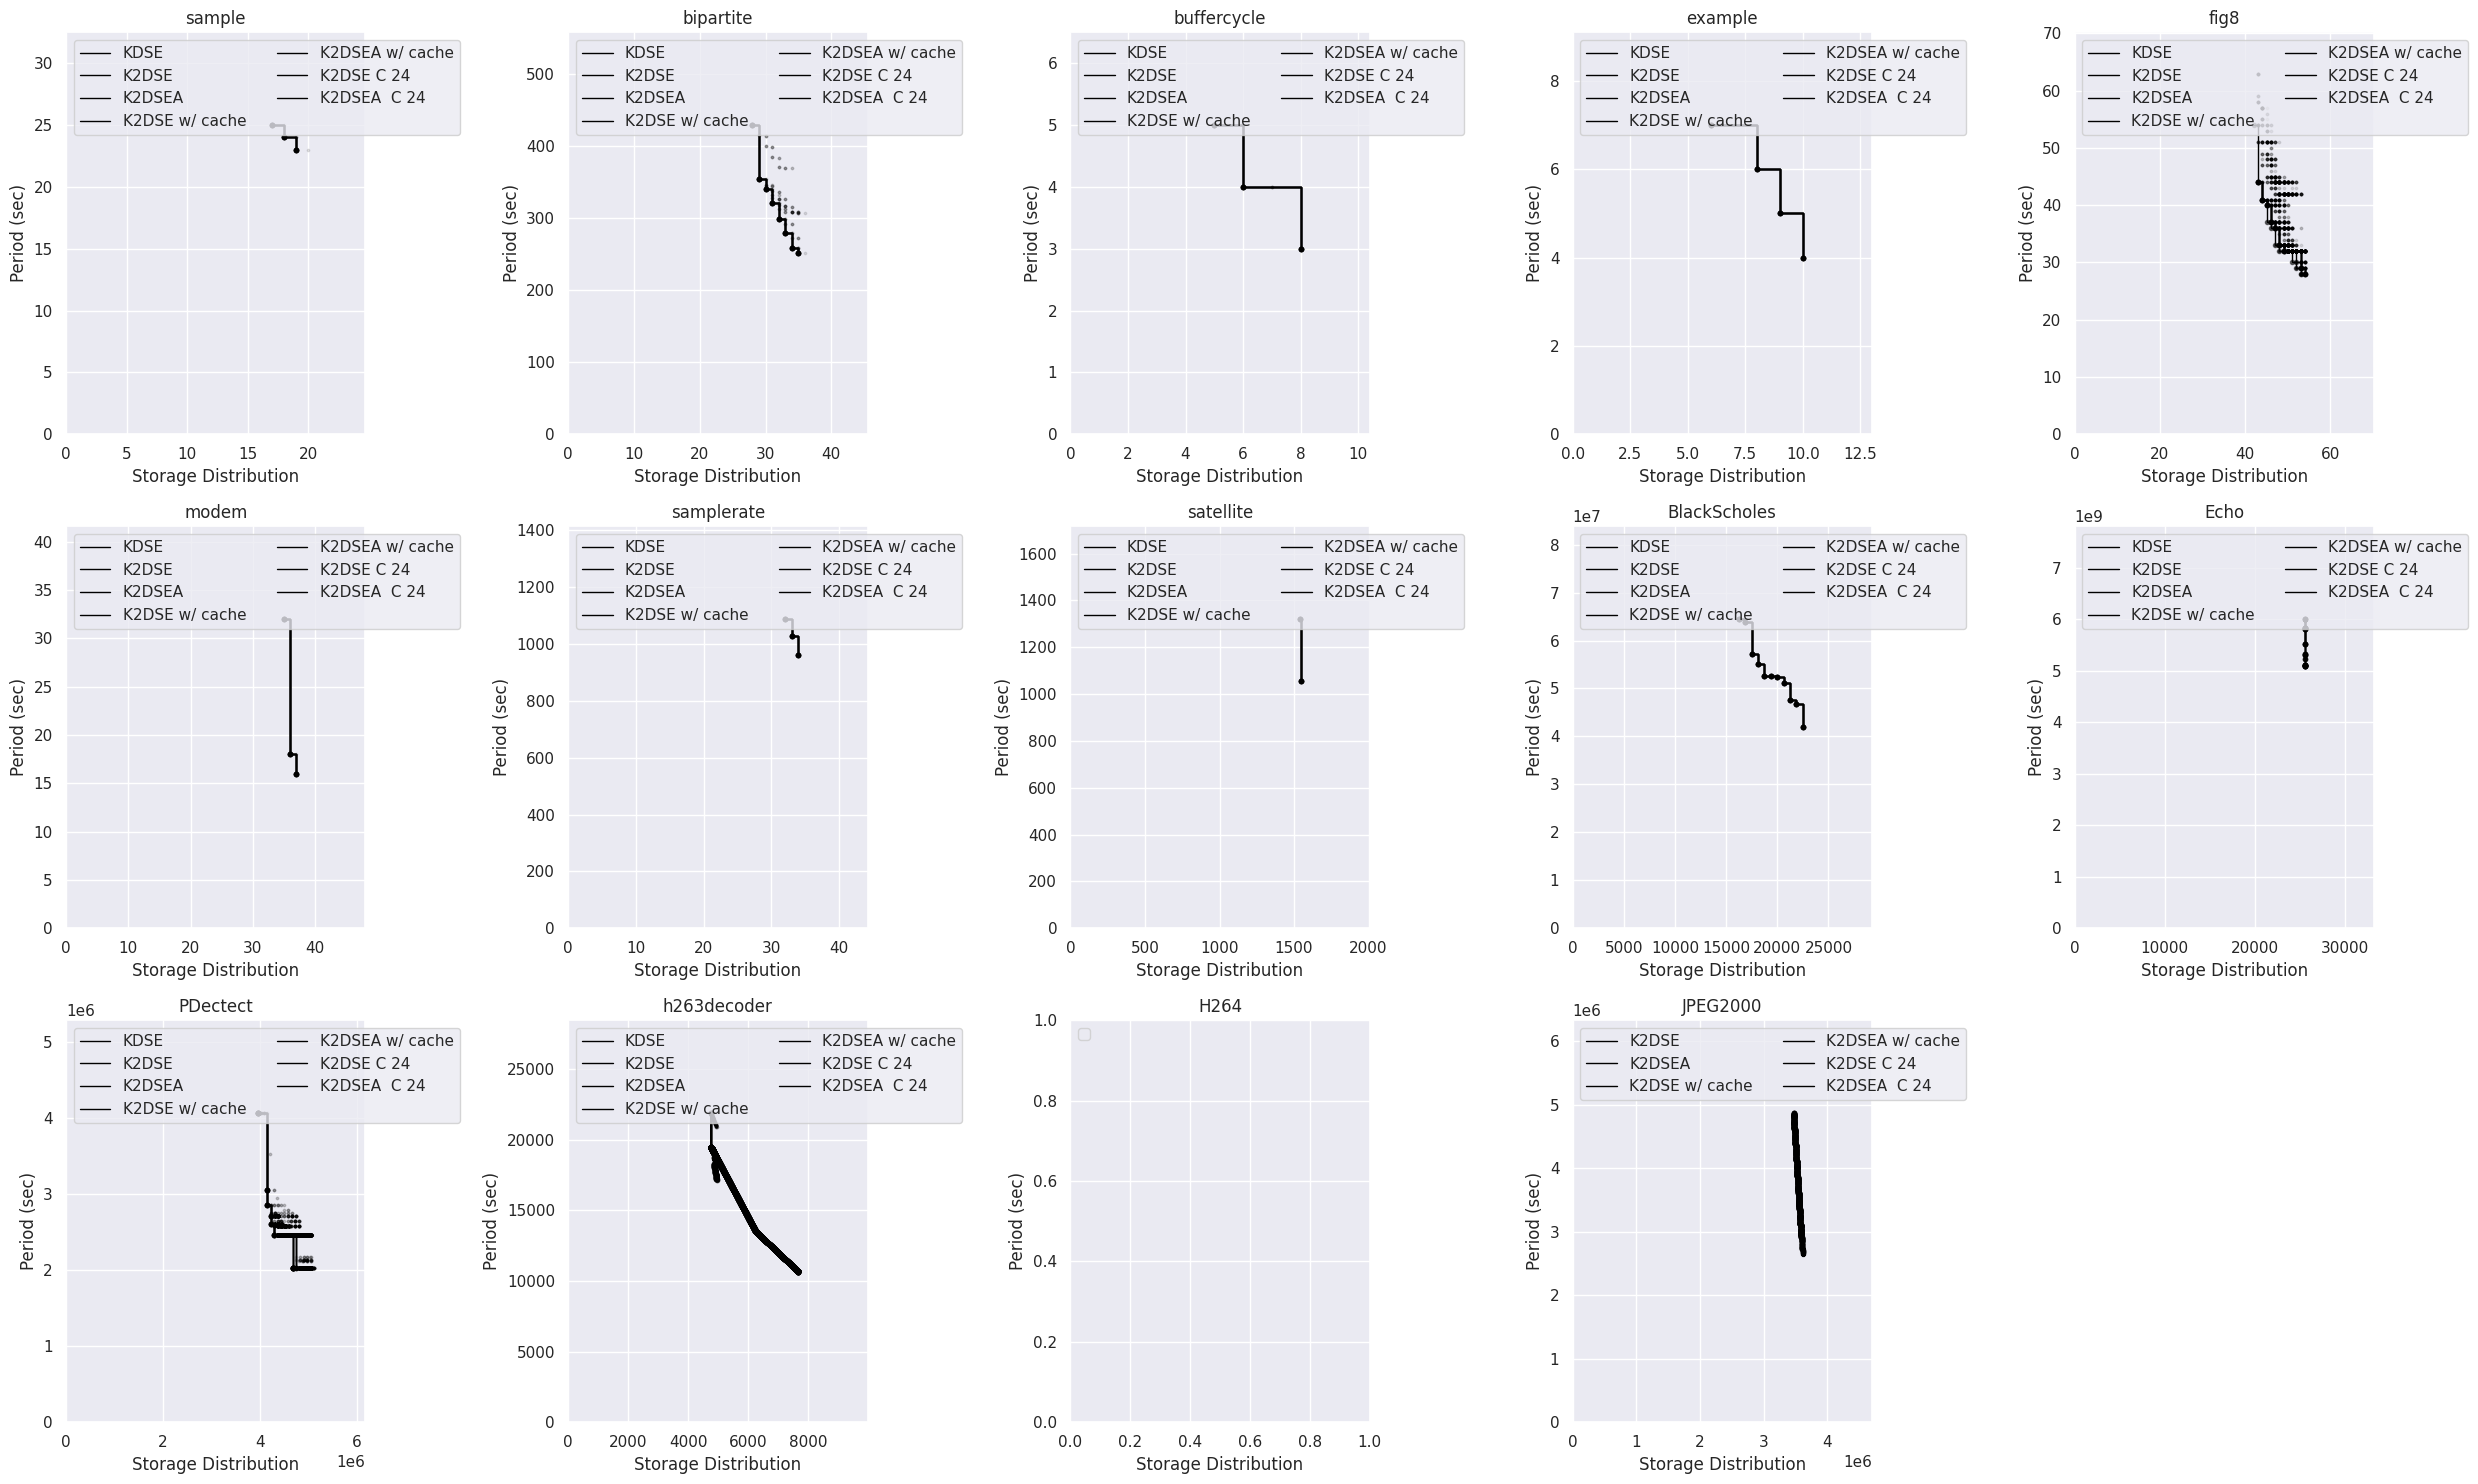

In [3]:
dsereader.plot_all(logdir, graphs=log_infos.keys(), methods=method_names, plotfunc=dsereader.plot_app_pareto)

In [4]:
import math 

def gen_dse_data(infos, columns=None):
    if columns is None:
        columns = ["throughput",
                   "storage distribution size",
                   "cumulative duration"]
    list_of_dict = []

    for app,app_infos in infos.items():
        if not "max_throughput" in app_infos or not "task_count" in app_infos:
            print ("No such application", app)
            continue
        app_name = app_infos["name"]
        app_max_throughput = app_infos["max_throughput"]
        app_task_count = app_infos["task_count"]
        for m in app_infos["logs"].keys():
            method_name = method_names[m]["name"]
            try :
                df = dsereader.load_app_dse(logdir, app, m, cols = columns)
                print(df.info())
            except FileNotFoundError:
                df = pd.DataFrame()
            sd_count = df["storage distribution size"].count() if "throughput" in df else "-"
            max_th = df["throughput"].max() 
            duration = df["cumulative duration"].max()  if "cumulative duration" in df else "-"
            print(app, m, max_th, app_max_throughput)
            finished = math.isclose(float(max_th), float(app_max_throughput), rel_tol=1e-5)
            pareto = dsereader.extract_pareto(df[["throughput","storage distribution size"]])
            pareto_count = pareto["storage distribution size"].count() if finished else "-"
            list_of_dict += [{"graph" : app_name, 
                                "#task" : app_task_count,
                                "method" : method_name, 
                                "#SD" : sd_count,
                                "#Pareto" : pareto_count,
                                "Duration" : int(duration), 
                                "Finished" : finished}]
            
    return pd.DataFrame(list_of_dict)

In [5]:
df = gen_dse_data(log_infos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   storage distribution size  6 non-null      int64  
 1   throughput                 6 non-null      float64
 2   cumulative duration        6 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 276.0 bytes
None
sample k2dse 0.0434783 0.0434782609
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   storage distribution size  5 non-null      int64  
 1   throughput                 5 non-null      float64
 2   cumulative duration        5 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 252.0 bytes
None
sample k2dseac 0.0434783 0.0434782609
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [6]:
df

,graph,#task,method,#SD,#Pareto,Duration,Finished
0,sample,3,K2DSE,6,3,2,True
1,sample,3,K2DSEA w/ cache,5,3,2,True
2,sample,3,K2DSE w/ cache,6,3,2,True
3,sample,3,K2DSEA,5,3,2,True
4,sample,3,K2DSE C 24,7,3,2,True
...,...,...,...,...,...,...,...
93,JPEG2000,240,K2DSE w/ cache,5175,-,3599480,False
94,JPEG2000,240,K2DSEA,7496,-,3599460,False
95,JPEG2000,240,K2DSE C 24,8958,-,3599700,False
96,JPEG2000,240,KDSE,6855,-,3599700,False


In [7]:

# Converting to DataFrame
#index = pd.MultiIndex.from_tuples([k for k in data.keys()], names=['Application', '#Task', 'Method'])
#df = pd.DataFrame(data.values(), index=index, columns=['Duration', 'Finished'])

def compare_methods(df, methods):
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Ensure the DataFrame is in the expected format
    df = df.set_index(["graph", "#task", "method"])
    
    # Initialize an empty DataFrame for comparison
    comparison_df = pd.DataFrame()
    
    # Loop through each method, extract its data, and add it to the comparison DataFrame
    for method in methods:
        method_data = df.xs(method, level='method')
        # If the comparison DataFrame is empty, just add the first method's data
        if comparison_df.empty:
            comparison_df = method_data.rename(columns={'Duration': f'Duration_{method}'})
        else:
            # If not, join with the existing data
            comparison_df = comparison_df.join(method_data['Duration'].rename(f'Duration_{method}'))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'yellow']  # Extend this list for more methods
    position = 0  # Initial bar position
    
    for idx, method in enumerate(methods):
        comparison_df[f'Duration_{method}'].plot(kind='bar', color=colors[idx % len(colors)], position=len(methods)-position, width=1 / (1 + len(methods)), label=method)
        position += 1  # Move position for the next bar
    
    plt.ylabel('Duration')
    plt.title('Comparison of Duration between Methods')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


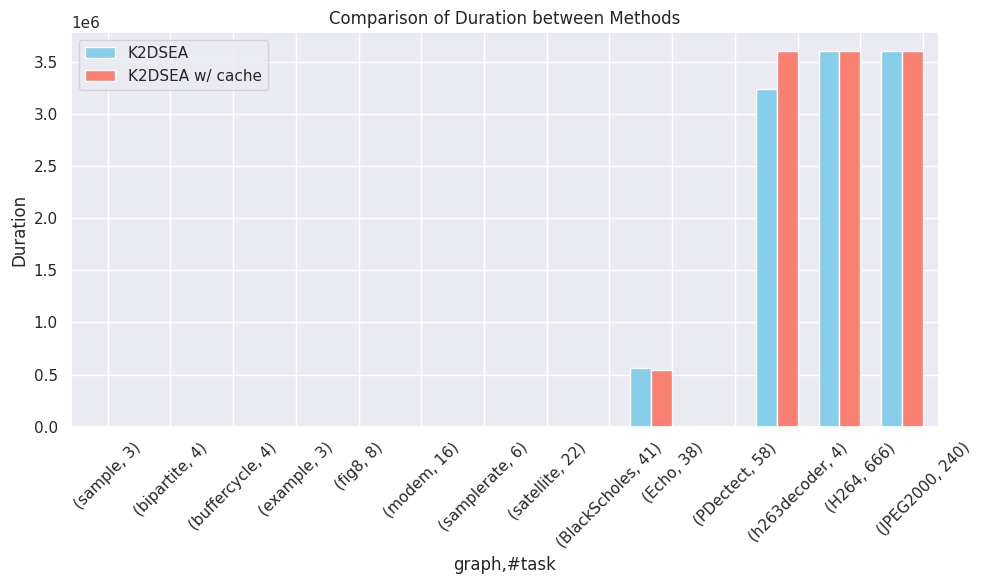

In [8]:
compare_methods(df, [ 'K2DSEA',  'K2DSEA w/ cache'])

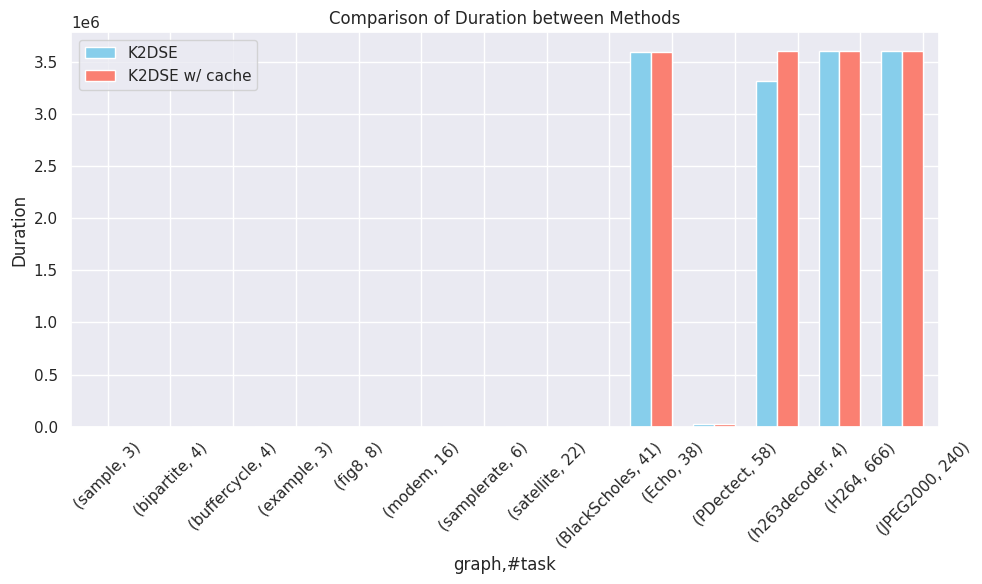

In [9]:

compare_methods(df, [ 'K2DSE',  'K2DSE w/ cache'])

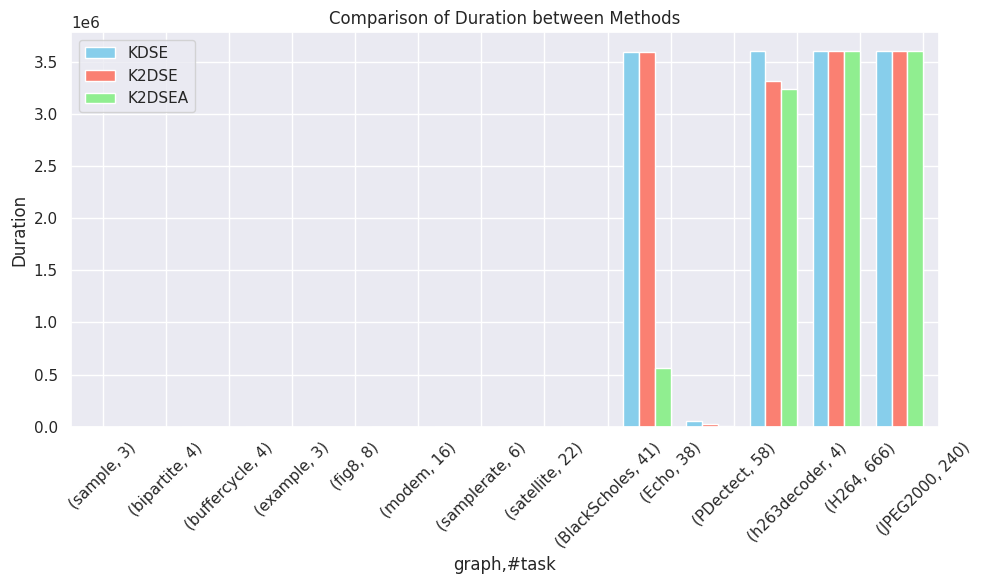

In [11]:
compare_methods(df, methods = ['KDSE', 'K2DSE', 'K2DSEA'])

<Figure size 1000x600 with 0 Axes>

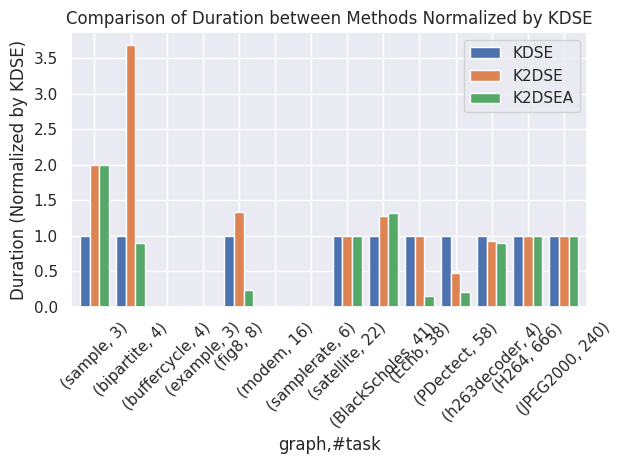

In [12]:
def compare_methods(df, methods, baseline):
    import matplotlib.pyplot as plt
    import pandas as pd

    # Ensure the DataFrame is set with the right multi-index
    df2 = df.set_index(["graph", "#task", "method"])

    # Initialize a dictionary to hold data for all methods
    normalized_data = {}

    # Get baseline data for normalization
    baseline_data = df2.xs(baseline, level='method')

    # Iterate through methods to calculate normalized duration
    for method in methods:
        method_data = df2.xs(method, level='method')
        # Calculate normalized duration as current method duration divided by baseline method duration
        # Join on index to align corresponding tasks, fill missing values to handle tasks not present in both methods
        normalized_duration = method_data['Duration'].div(baseline_data['Duration'], fill_value=1)
        # Store normalized data
        normalized_data[method] = normalized_duration

    # Convert the dictionary to a DataFrame for plotting
    comparison_df = pd.DataFrame(normalized_data)

    # Plotting
    plt.figure(figsize=(10, 6))
    comparison_df.plot(kind='bar', width=0.8)
    plt.ylabel(f'Duration (Normalized by {baseline})')
    plt.title(f'Comparison of Duration between Methods Normalized by {baseline}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
compare_methods(df, methods = ['KDSE', 'K2DSE', 'K2DSEA'], baseline="KDSE")


<Figure size 1000x600 with 0 Axes>

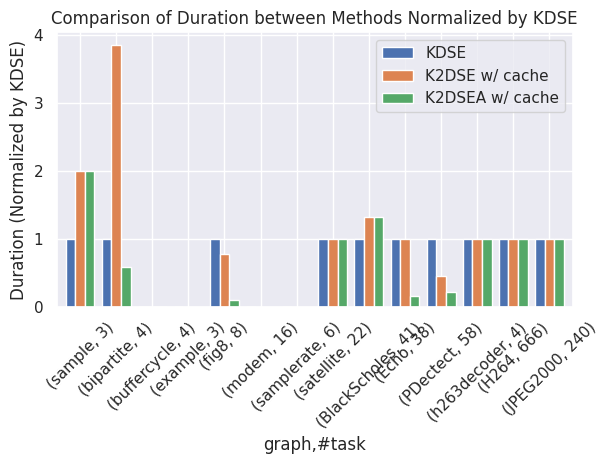

In [13]:

compare_methods(df, methods = ['KDSE', 'K2DSE w/ cache', 'K2DSEA w/ cache'], baseline="KDSE")

<Figure size 1000x600 with 0 Axes>

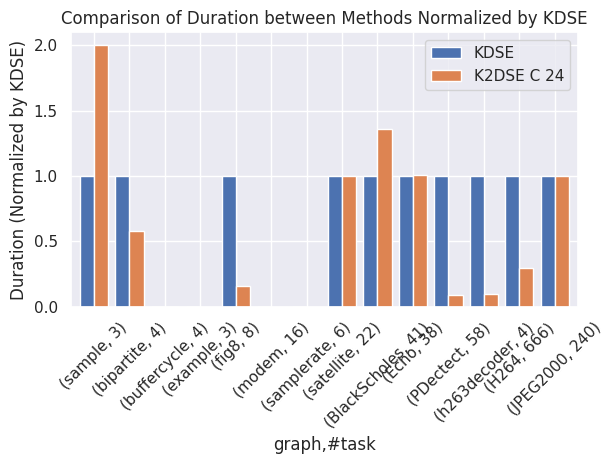

In [14]:

compare_methods(df, methods = [ "KDSE",  'K2DSE C 24' ], baseline="KDSE")

In [15]:
col_format = "|".join([""] + ["l"] * df.index.nlevels + ["r"] * df.shape[1] + [""])
               
latex = df.to_latex(
        float_format="{:0.1f}".format # , column_format=col_format, index=False
    )

## 0.1 Check the correctness of the new algorithm

❌ We explore less for fig8,and 
❌ We explore more for BlackScholes. This is due to a difference in OldKDSE when they initialize the first SD. they are correct with this particular app, but their init could be wrong. We stick to the curren one, can be improved later.
❌ There are strange artefact when looking at sample output from OldKDSE, it sets buffers to values higher than required at initilization, it is a bug in OldKDSE.


## 0.2 and 0.3 Check non-threaded and threaded versions are faster

When effective we gain one order of magnitude.
When not, we lose a few seconds maximum.
On my machine 16 is too much.

## 0.3bis Check threaded version has no duplicates

The following test ensure the threaded version does not explore twice the same point. 

In [16]:
def sanity_check(logdir, applications, methods):
    for app_key,app_values in applications.items():
        
        if not "max_throughput" in app_values or not "task_count" in app_values:
            continue
            
            
        for method_key,method_values in methods.items():
            
            
            app_name = app_values["name"]
            app_task_count = app_values["task_count"]
            method_name = method_values["name"]
            
            try :
                df = dsereader.load_app_dse(logdir, app_key, method_key, cols = ["throughput", 
                                                                                 "storage distribution size",
                                                                                 "cumulative duration",
                                                                                 "feedback quantities"])
            except FileNotFoundError:
                continue
            except ValueError:
                continue

            # assert it finished
            max_th = df["throughput"].max() 
            app_max_throughput = app_values["max_throughput"]
            finished = math.isclose(max_th, app_max_throughput, rel_tol=1e-5)
            assert(finished)

            # assert there is no duplicates
            duplicates_count = len(df["feedback quantities"]) - len(df["feedback quantities"].drop_duplicates())
            assert(duplicates_count == 0)

            print(app_key, method_key, finished, duplicates_count)
        
    return True

In [17]:
sanity_check(logdir, applications=applications, methods=methods)

NameError: name 'applications' is not defined

# What do we do next

The KDSE2 algorithm is recursive. The first level is global, the second level is local. 

## Improve the local level

There is no way to get deeper, the local level is a single cycle. But single cycle are usually small, so we can accelerate this part by using static knowledge. For example the distribution size for a cycle must be greater than X to improve the throughput. 

## Improve the global level

At the global level, instead of restarting the local level again and again for a same cycle, we could use a cache that store the result.

In [38]:
pd.read_csv(f"{logdir}bipartite_kdse.txt")

,storage distribution size,throughput,channel quantities,feedback quantities,critical channels,critical feedback,duration,cumulative duration
0,28,0.002331,"0,0,0,0","6,6,4,12","3,4","3,4",0.346451,0.493920
1,29,0.002410,"0,0,0,0","6,6,4,13","1,3,4","2,3,4",0.306268,0.844094
2,29,0.002825,"0,0,0,0","6,6,5,12","2,3,4","1,3,4",0.263532,1.145630
3,30,0.002500,"0,0,0,0","6,6,4,14","1,3,4","2,3,4",0.204463,1.379950
4,30,0.002899,"0,0,0,0","6,6,5,13","1,2,3,4","1,2,3,4",0.241127,1.643580
5,30,0.002933,"0,0,0,0","6,6,6,12","2,3,4","1,4",0.262327,1.935190
6,30,0.002415,"0,0,0,0","6,7,4,13","3,4","3,4",0.258072,2.219780
7,30,0.002890,"0,0,0,0","7,6,5,12","3,4","3,4",0.269460,2.510300
8,31,0.002597,"0,0,0,0","6,6,4,15","1,3,4","2,3,4",0.214497,2.746620
9,31,0.003049,"0,0,0,0","6,6,5,14","1,2,3,4","1,2,3,4",0.389356,3.159320
